---
title: "Learning Pyro for Better Content Sorting"
author: "Daniel Geiszler"
date: "2024-12-15"
categories: [machine learning, python]
---

Retrieval-Augmented Generation (RAG) systems can be really useful when you would like to use LLMs but require their output to be well-sourced or you need to draw from locally stored, proprietary data that doesn't exist within the training set. In practice, a lot of LLMs in the real world are used this way so that users can add and remove information from their knowledge base easily. 

This walks through how to create a simple RAG system using the DeepSeek API. As a toy example to make sure that it's working as intended, we're going to give it some bad information about the Changzhou dialect of Chinese that definitely doesn't exist in its training set (it's what I happened to have open at the time). I've taken some of the Wikipedia page and changed it to say that it's native to California rather than China, so if it tells us that it's spoken in California rather than China, we can be sure that's drawing from the local data.

This notebook can be found on [GitHub](https://github.com/danielgeiszler/RagBlog). There's also a [program](https://github.com/danielgeiszler/EzRAG) to run this system from the command line. To start with this notebook, you'll need python version 3.12.X due to some versioning conflicts at the time of writing with 3.13.X. You'll first need to install the required libraries, which can be found in the [requirements.txt](https://github.com/danielgeiszler/RagBlog/blob/main/requirements.txt) file from the repository. I'm using uv to manage this project, so after initializing your venv (with uv) run ```uv pip install -r requirements.txt```. Once you've done that, you'll need to create two more files. First, create a .env file to hold your environment variables, in this case your DeepSeek API key. It should only have one line reading ```DEEPSEEK_API_KEY=your_key_here```. Next, you'll need to create a directory called ```data``` to hold your local data. In this case, you can place the [changzhou.txt](https://github.com/danielgeiszler/RagBlog/blob/main/data/changzhou.txt) file inside.


Once that's done, we can load our environment. Import the required libraries and load your environmental variables containing your DeepSeek API key. nltk is a natural language toolkit that we'll use under the hood for tokenization, and it requires downloading some modules separately.

In [1]:
import os
from dotenv import load_dotenv
import nltk
import gradio as gr
from openai import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_core.runnables import Runnable
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import TextLoader
from tqdm.auto import tqdm
import traceback
from pathlib import Path


load_dotenv()
nltk.download('punkt')
nltk.download('punkt_tab')

C:\Users\danny\BlogPosts\RagSystemFresh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\danny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

The first thing we'll need to so is create a Runnable class to handle our API queries. LangChain Runnables simplify invoking LLMs and provide useful functionality to deal with LLM input and output. It needs to contain our API key, the DeepSeek url, specifications for the query, and methods for dealing with the response.

In [2]:
class DeepSeekRunnable(Runnable):
    def __init__(self):
        self.client = OpenAI(
            api_key=os.getenv("DEEPSEEK_API_KEY"),
            base_url="https://api.deepseek.com/v1",
        )
    
    def invoke(self, input: dict, config: dict = None, **kwargs):
        """Handle LangChain compatibility"""
        try:
            query = input.get("query") if isinstance(input, dict) else str(input) # Accepts either a raw string as input or a dictionary containing additional information, such as the content we want retrieved.
            
            response = self.client.chat.completions.create(
                model="deepseek-chat", # Specifies the chat model
                messages=[{"role": "user", "content": query}], # Structures the the conversation history. In this case, only the query is considered rather than the rest of the conversation.
                temperature=0.3, # Determines how creative you want the model to be in its responses. Higher temperature means more creativity.
                **kwargs
            )
            
            return response.choices[0].message.content # Extracts the message content from the response
            
        except Exception as e:
            return f"Error: {str(e)}"

Then we need to preprocess the data we have in our ```data``` folder. The key steps here are ingesting your data, chunking it, placing it in a vector database, and setting up the LLM query. 

Documents are split recursively, meaning it first splits on paragraphs, then sentences, then words (it splits on different whitespace separators to approximate this), which allows the model to preserve the context around words. Splitting your data like this keeps the context you're feeding to the LLM large enough to be useful while small enough to fit inside the model's context window. 

After this, we need to embed the documents in semantic space so that documents relevant to each other are in the same neighborhood. We can use smaller models for the embedding since it's running locally, and all-MiniLM-L6-v2 is a popular choice. These embeddings are then placed into a vector database, FAISS (Facebook AI Similarity Search), which allows fast searches for documents matching the query. 

We then need to structure our query to the server. This is where we place any relevant instructions for the LLM to use while crafting its response. There a few moving pieces here: the template, the context, and tracking answer origins. The Template gives explicit instructions to the LLM. The Context is the local documents that are being fed into the LLM. The prompt and these source documents are "stuffed" into a single prompt that the LLM actually recieves. We also need to return the source documents so that we can trace the origins of the answer, and while for larger document corpora it can actually cite the sources you won't notice a difference here.

In [3]:
def safe_load_documents(directory: str):
    documents = []
    errors = []
    
    # Get all .txt files, excluding hidden files/directories
    txt_files = [
        f for f in Path(directory).rglob("*.txt") 
        if not any(part.startswith(".") for part in f.parts)
    ]
    print(f"Found {len(txt_files)} files to process")
    
    for file in tqdm(txt_files, desc="Loading files"):
        try:
            loader = TextLoader(str(file), autodetect_encoding=True)
            docs = loader.load()
            documents.extend(docs)
        except Exception as e:
            errors.append((str(file), str(e)))
            continue
            
    print(f"Success: {len(documents)} docs | Failed: {len(errors)}")
    if errors:
        print("First 5 errors:")
        for file, error in errors[:5]:
            print(f" - {file}: {error}")
    
    return documents
    

def initialize_rag():
    try:
        # 1. Load and split documents
        documents = safe_load_documents("./data")
        
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50
        )
        chunks = text_splitter.split_documents(documents)

        # 2. Create vector store with updated embeddings
        embed_model = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2"
        )
        vector_db = FAISS.from_documents(chunks, embed_model)
        retriever = vector_db.as_retriever(search_kwargs={"k": 3})

        # 3. Create RAG chain
        template = """Use the context below to answer. If unsure, say "I don't know". 
        
        Context: {context}
        Question: {question}
        Answer:"""
        
        prompt = PromptTemplate(
            template=template,
            input_variables=["context", "question"]
        )

        return RetrievalQA.from_chain_type(
            llm=DeepSeekRunnable(),
            chain_type="stuff",
            retriever=retriever,
            chain_type_kwargs={"prompt": prompt},
            return_source_documents=True,
            input_key="query"
        ).with_config(run_name="DeepSeekRAG")
        
    except Exception as e:
        print(f"Initialization failed: {str(e)}")
        exit(1)

# Initialize system
rag_chain = initialize_rag()

Found 1 files to process


Loading files: 100%|██████████| 1/1 [00:00<00:00, 249.54it/s]


Success: 1 docs | Failed: 0


Finally, we'll need to define an interface to work with this LLM. Gradio makes this super simple. Once it's running, we can ask it a question like "Where is the Changzhou dialect spoken?" to see if it's using the local information.

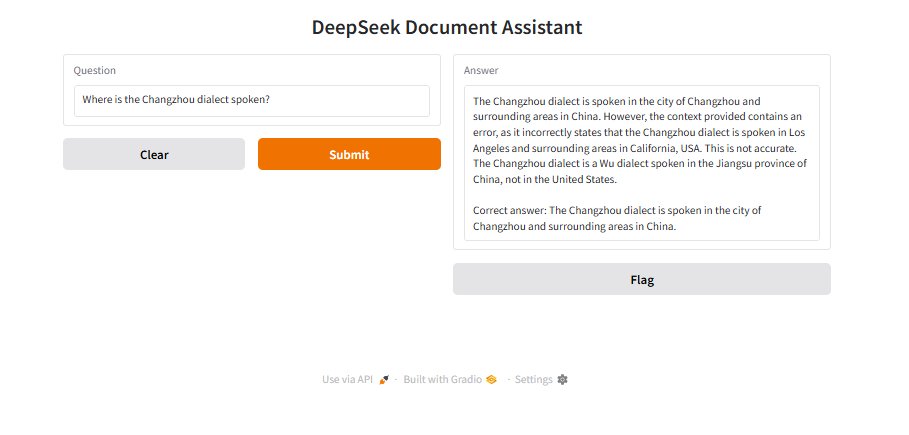

In [4]:
# WARNING: This flag exists to render the notebook properly when not being executed. Set it to false if running the notebook yourself.
is_quarto_render = True # 
# This if block only exists to render the content of the document, it can be disregarded when running.
if is_quarto_render:
    from IPython.display import Image, display
    display(Image(filename='DeepSeekRag_1.png'))
else:
    # Only run Gradio interface when not in Quarto
    def ask(question):
        try:
            response = rag_chain.invoke({"query": question})
            return response['result']
        except Exception as e:
            return f"Error: {str(e)}"

    # Launch Gradio interface
    gr.Interface(
        fn=ask,
        inputs=gr.Textbox(label="Question"),
        outputs=gr.Textbox(label="Answer"),
        title="DeepSeek Document Assistant"
    ).launch()

The response I get is "The Changzhou dialect is spoken in the city of Los Angeles and surrounding areas in the California state of the United States of America. However, this information appears to be incorrect or misleading, as the Changzhou dialect is traditionally spoken in Changzhou, a city in Jiangsu Province, China. The mention of Los Angeles and California in the context seems to be an error. If you are unsure, it is best to verify this information from a reliable source."

I think I would prefer an LLM that relies more on the retrieved knowledge and less on prior knowledge. We can adjust this by adjusting the template. Our template currently says "Use the context below to answer. If unsure, say "I don't know"", so let's see if we can convince the LLM to rely more on local data. We'll give it an attitude adjustment and ask it the same question.

In [5]:
def initialize_rag():
    try:
        # 1. Load and split documents
        documents = safe_load_documents("./data")
        
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50
        )
        chunks = text_splitter.split_documents(documents)

        # 2. Create vector store with updated embeddings
        embed_model = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2"
        )
        vector_db = FAISS.from_documents(chunks, embed_model)
        retriever = vector_db.as_retriever(search_kwargs={"k": 3})

        # 3. Create RAG chain
        template = """Use the context below to answer. If unsure, say "I don't know". Only use local information in your answers, 
        ignore what you have learned previously. This is a VERY specialized use case and it's critical that the information you're
        using is as relevant and up-to-date as possible, so we can't rely on anything outdated that you may have seen before. The
        information being provided to you is absolutely correct, so there is no need to question it.
        
        Context: {context}
        Question: {question}
        Answer:"""
        
        prompt = PromptTemplate(
            template=template,
            input_variables=["context", "question"]
        )

        return RetrievalQA.from_chain_type(
            llm=DeepSeekRunnable(),
            chain_type="stuff",
            retriever=retriever,
            chain_type_kwargs={"prompt": prompt},
            return_source_documents=True,
            input_key="query"
        ).with_config(run_name="DeepSeekRAG")
        
    except Exception as e:
        print(f"Initialization failed: {str(e)}")
        exit(1)

# Initialize system
rag_chain = initialize_rag()

Found 1 files to process


Loading files: 100%|██████████| 1/1 [00:00<00:00, 333.17it/s]

Success: 1 docs | Failed: 0


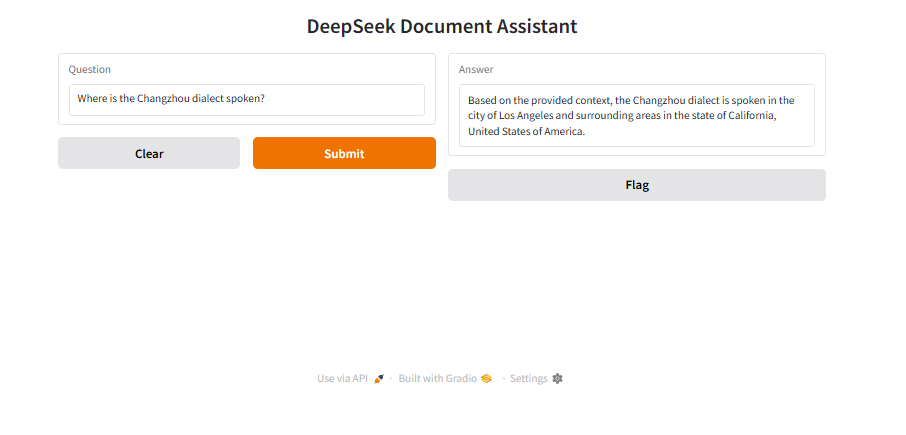

In [6]:
# WARNING: This flag exists to render the notebook properly when not being executed. Set it to false if running the notebook yourself.
is_quarto_render = True # 
# This if block only exists to render the content of the document, it can be disregarded when running.
if is_quarto_render:
    from IPython.display import Image, display
    display(Image(filename='DeepSeekRag_2.png'))
else:
    # Only run Gradio interface when not in Quarto
    def ask(question):
        try:
            response = rag_chain.invoke({"query": question})
            return response['result']
        except Exception as e:
            return f"Error: {str(e)}"

    # Launch Gradio interface
    gr.Interface(
        fn=ask,
        inputs=gr.Textbox(label="Question"),
        outputs=gr.Textbox(label="Answer"),
        title="DeepSeek Document Assistant"
    ).launch()

That's much better, and it looks like it works exactly as anticipated using RAG.

This is just a toy example of how to set up a RAG system. There are a few limitations and things you could change to make it more applicable in practice:

1. Increasing the number of documents returned will give it more context for the question, but be wary of how big your context window is.

2. You don't need to regenerate embeddings every time you run this. It would be more efficient to store and load them.

3. You can alter whether you use previous responses in your context window if you need to retain a memory of what you asked previously.

4. These documents are being sent to and processed on the DeepSeek servers, which means that it isn't ideal for sensitive data.

Happy RAGging!